<a href="https://colab.research.google.com/github/nafisenik/NLP-CA2/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
!pip install ner-d

In [2]:
import os
import pandas as pd
from itertools import groupby
from operator import itemgetter
import re
from collections import Counter
import numpy as np
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
import string



from nltk import regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import spacy
from spacy import displacy

from nerd import ner

import datetime

### Download nltk packages

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Read text files and save as a list

In [4]:
# a function to read files 
def read_file(file):
    with open(file, 'r', encoding="utf-8") as f:
        text = f.read()
    return text

# set path to text files
file_dir = './Data/Text_Files/'
text_list = []

# find files with .txt and read them
for file in os.listdir(file_dir):
    if file.endswith(".txt"):
        file_path = f'{file_dir}{file}'
        text_list.append(read_file(file_path))

In [5]:
print(f"number of texts: {len(text_list)}")

number of texts: 82


### Sample of our data

In [6]:
# sample text
print(f"sample text: {text_list[0][:500]}")

sample text: 
[As delivered in person before a joint session]
Mr. Vice President, my old colleague from Massachusetts and your new Speaker, John McCormack, Members of the 87th Congress, ladies and gentlemen:
This week we begin anew our joint and separate efforts to build the American future. But, sadly, we build without a man who linked a long past with the present and looked strongly to the future. "Mister Sam" Rayburn is gone. Neither this House nor the Nation is the same without him.
Members of the Congre


In [7]:
df = pd.read_csv("./Data/metadata.csv")
df.head()

,Index,President,Categories,Date,Citation,Title
0,0,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 06, 1947","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
1,1,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 07, 1948","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
2,2,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 05, 1949","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
3,3,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 04, 1950","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
4,4,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 08, 1951","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...


#### Change Date Type to datetime

In [8]:
print(df['Title'].dtypes)

object


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
df['Date']

0    1947-01-06
1    1948-01-07
2    1949-01-05
3    1950-01-04
4    1951-01-08
        ...    
77   2016-01-12
78   2018-01-30
79   2019-02-05
80   2020-02-04
81   2022-03-01
Name: Date, Length: 82, dtype: datetime64[ns]

### Groupby persidents:
`dict[president_name]` = `[texts]`


In [10]:
president_name = df['President'].tolist()
president_text_dict = {keys: [i for _, i in sub] for keys, sub in groupby(
         zip(president_name, text_list), key = itemgetter(0))}

In [11]:
president_text_dict.keys()

dict_keys(['Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard Nixon', 'Gerald R. Ford', 'Jimmy Carter', 'Ronald Reagan', 'George Bush', 'William J. Clinton', 'George W. Bush', 'Barack Obama', 'Donald J. Trump', 'Joseph R. Biden'])

In [12]:
len(president_text_dict['Barack Obama'])

7

### Tokenizer

In [13]:
# http://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[a-zA-Z]\.)+(?:[a-zA-Z])?         # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

def tokenize_text(text):
    return regexp_tokenize(text, pattern)

### Lemmatizer

In [14]:
def lemmatize_all(sentence):
    l = []
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(tokenize_text(sentence)):
        if tag.startswith('N'):
            l.append(wnl.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            l.append(wnl.lemmatize(word, pos='v'))
        elif tag.startswith('J'):
            l.append(wnl.lemmatize(word, pos='a'))
        elif tag.startswith('R'):
            l.append(wnl.lemmatize(word, pos='r'))
            
        else:
            l.append(wnl.lemmatize(word, pos='n'))
    return l

#### Test of lemmatizer

In [15]:
sentence_sample = 'The striped bats are  hanging on their feet for best and wrote you are'
print(lemmatize_all(sentence_sample))



['The', 'striped', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best', 'and', 'write', 'you', 'be']


### Normalizing and Cleaning

In [16]:
stop_words = set(stopwords.words('english'))
def normalize_and_cleaning(text, lemm=True, remove_punct=True, lower=True, stop_word=True, remove_number=True, min_len = 2):

    text = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
    

    word_tokens = tokenize_text(text)
    
    if lower:
        text = text.lower()
    
    
    if remove_number:
        my_reg = r'\$?\d+\.?\d*\w*\d*'
        text = re.sub(my_reg, '', text)
    
    if remove_punct:
        #text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if len(word) > 1])
        text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if word not in string.punctuation])
    
    if lemm:
      text = ' '.join(lemmatize_all(text))
    
    
    if stop_word:
        text = ' '.join([w for w in tokenize_text(text) if not w.lower() in stop_words])
    

    
    if min_len>1:
        text = ' '.join([word for word in tokenize_text(text) if len(word)>min_len])  

    
    text = re.sub(' +', ' ', text)
    
    return text
    
    

In [17]:
#Test normalize_and_cleaning
test_text ='''[Laughter]poster-print The President. That 1993s Asia—the asia-pacific 22nd 33nd33 6-year U.S.A. wrote good example. [Applause] Well—[applause]. are [Applause] costs $12.40... Michelle Move! u.'''
tokens = tokenize_text(test_text)
res = normalize_and_cleaning(test_text)
res2 = normalize_and_cleaning(test_text,remove_number=False)
print(res)

print(res2)



poster-print president asia asia-pacific year u.s.a write good example well cost michelle move
poster-print president 1993s asia asia-pacific 22nd 33nd33 6-year u.s.a write good example well cost michelle move


### Join all text and create our corpuse

In [18]:
all_doc = ' '.join(text_list)
clean_corpuse = normalize_and_cleaning(all_doc)
corpuse_tokens = tokenize_text(clean_corpuse)


### Most frequent words of our corpuse

In [19]:
counter = Counter(corpuse_tokens)
most_occur = counter.most_common(50)
corpuse_fre_df = pd.DataFrame.from_records(most_occur, columns =['word', 'frequency'])
total_freq = [(x[1]/len(corpuse_tokens))*100 for x in most_occur]
corpuse_fre_df['% total frequency'] = total_freq
corpuse_fre_df

,word,frequency,% total frequency
0,year,3291,1.132855
1,american,2114,0.727698
2,new,2047,0.704635
3,people,1904,0.655410
4,nation,1870,0.643707
5,must,1848,0.636134
6,make,1829,0.629593
7,congress,1828,0.629249
8,program,1773,0.610317
9,world,1747,0.601367


### Statistical information

In [20]:
def Statistical_info(text_tokens):
  print (f"Number of words : {len(text_tokens)}")
  print (f"Number of unique  words : {len(set(text_tokens))}")
  word_len_avg = sum(map(len, text_tokens))/float(len(text_tokens))
  print (f"Average word length : {word_len_avg}")
  sent_len_avg = np.mean([len(' '.join(s)) for s in text_tokens])
  max_w = max(text_tokens, key=len)
  min_w = min(text_tokens, key=len)
  print (f"Longest word : {max_w}")
  print (f"Shortest word : {min_w}")

### Word cloud of corpuse

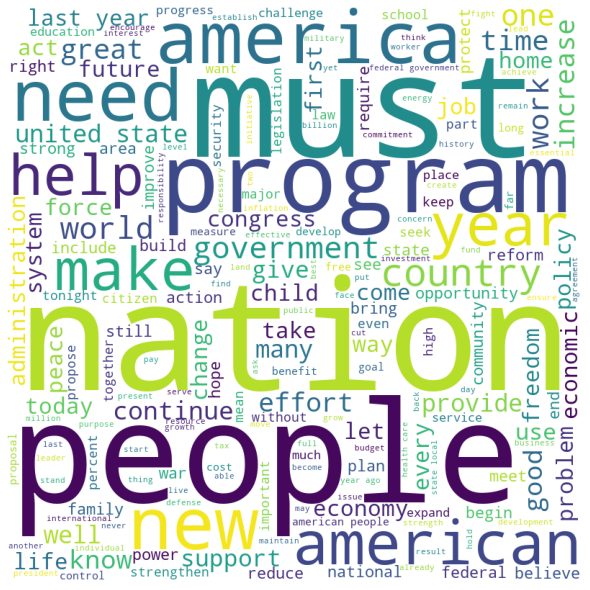

In [21]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(clean_corpuse)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Statistical information of corpuse

In [22]:
  print('*' *50)
  print('Statical information of corpus')
  print('*' *50)
  Statistical_info(corpuse_tokens)

**************************************************
Statical information of corpus
**************************************************
Number of words : 290505
Number of unique  words : 12245
Average word length : 6.419245796113664
Longest word : weapons-of-mass-destruction-related
Shortest word : old


###Statistical information for each president

In [23]:
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  president_tokens = tokenize_text(clean_text)
  print('*' *50)
  print(president)
  print('*' *50)
  Statistical_info(president_tokens)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/14 [00:00<?, ?it/s]

**************************************************
Harry S. Truman
**************************************************
Number of words : 18727
Number of unique  words : 3654
Average word length : 6.144710845303573
Longest word : popular-particularly
Shortest word : old
**************************************************
Dwight D. Eisenhower
**************************************************
Number of words : 30014
Number of unique  words : 4546
Average word length : 6.237155993869528
Longest word : politically-inspired
Shortest word : new
**************************************************
John F. Kennedy
**************************************************
Number of words : 17509
Number of unique  words : 3301
Average word length : 6.740476326460677
Longest word : under-representation
Shortest word : new
**************************************************
Lyndon B. Johnson
**************************************************
Number of words : 14230
Number of unique  words : 3254
Average word 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
all_p_text =[]
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  all_p_text.append(clean_text)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/14 [00:00<?, ?it/s]

### Clustering

In [25]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
X = vectorizer.fit_transform(all_p_text)
vectorizer.get_feature_names_out()
print(X.shape)
#X = vect.fit_transform(docs) 
count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
count_vect_df
#X_df = pd.DataFrame(X)


(14, 12245)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a.d,a.m.e,aaron,abandon,abandoned,abandonment,abate,abatement,abbas,abdication,...,zero-based,zero-emission,zest,zigzag,zimbabwe,zimbabwe-can,zimbabwean,zion,zone,zoom
0,0.000000,0.000000,0.000000,0.011153,0.000000,0.000000,0.000000,0.000000,0.000000,0.003399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003662,0.000000
1,0.000000,0.002441,0.000000,0.000000,0.000000,0.000000,0.001880,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002441,0.000000,0.000000,0.000000,0.002441,0.003414,0.000000
2,0.000000,0.000000,0.000000,0.006550,0.000000,0.003108,0.000000,0.000000,0.000000,0.000000,...,0.003494,0.004037,0.000000,0.000000,0.002810,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.006115,0.000000,0.003869,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007026,0.000000
4,0.000000,0.000000,0.000000,0.004292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004110,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.006455,0.000000,0.003063,0.001532,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002769,0.000000,0.003978,0.000000,0.002781,0.001989
7,0.000000,0.000000,0.000000,0.002553,0.003146,0.000000,0.000000,0.002723,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005867,0.000000
8,0.000000,0.000000,0.000000,0.002900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.003075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
y = kmeans.fit_predict(X)
p_names = list(president_text_dict.keys())
vect_df = pd.DataFrame(p_names, columns = ['President'])
vect_df['Label'] = y

In [27]:
vect_df

,President,Label
0,Harry S. Truman,0
1,Dwight D. Eisenhower,0
2,John F. Kennedy,2
3,Lyndon B. Johnson,0
4,Richard Nixon,2
5,Gerald R. Ford,0
6,Jimmy Carter,2
7,Ronald Reagan,0
8,George Bush,0
9,William J. Clinton,2


In [28]:
final_df = pd.concat([vect_df, count_vect_df], axis=1)
f = final_df.iloc[0:12,:]
f

,President,Label,a.d,a.m.e,aaron,abandon,abandoned,abandonment,abate,abatement,...,zero-based,zero-emission,zest,zigzag,zimbabwe,zimbabwe-can,zimbabwean,zion,zone,zoom
0,Harry S. Truman,0,0.000000,0.000000,0.0,0.011153,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003662,0.000000
1,Dwight D. Eisenhower,0,0.000000,0.002441,0.0,0.000000,0.000000,0.000000,0.001880,0.000000,...,0.000000,0.000000,0.000000,0.002441,0.000000,0.0,0.000000,0.002441,0.003414,0.000000
2,John F. Kennedy,2,0.000000,0.000000,0.0,0.006550,0.000000,0.003108,0.000000,0.000000,...,0.003494,0.004037,0.000000,0.000000,0.002810,0.0,0.000000,0.000000,0.000000,0.000000
3,Lyndon B. Johnson,0,0.000000,0.000000,0.0,0.006115,0.000000,0.003869,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007026,0.000000
4,Richard Nixon,2,0.000000,0.000000,0.0,0.004292,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.004110,0.000000
5,Gerald R. Ford,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Jimmy Carter,2,0.000000,0.000000,0.0,0.006455,0.000000,0.003063,0.001532,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002769,0.0,0.003978,0.000000,0.002781,0.001989
7,Ronald Reagan,0,0.000000,0.000000,0.0,0.002553,0.003146,0.000000,0.000000,0.002723,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.005867,0.000000
8,George Bush,0,0.000000,0.000000,0.0,0.002900,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,William J. Clinton,2,0.000000,0.000000,0.0,0.003075,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [29]:
num_clusters = 3
num_seeds = 3
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1'
}
pca_num_components = 2
tsne_num_components = 2

X1 = X.todense()
reduced_data = PCA(n_components=pca_num_components).fit_transform(X1)
# print reduced_data
dense_df = pd.DataFrame(reduced_data, columns=['X','Y'])
dense_df


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


'\nfig, ax = plt.subplots()\nfor index, instance in enumerate(reduced_data):\n    # print instance, index, labels[index]\n    pca_comp_1, pca_comp_2 = reduced_data[index]\n    color = labels_color_map[y[index]]\n    ax.scatter(pca_comp_1, pca_comp_2, c=color)\nplt.show()\n\n\n\n# t-SNE plot\nembeddings = TSNE(n_components=tsne_num_components)\nY = embeddings.fit_transform(X)\nplt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)\nplt.show()\n'

In [30]:
dense_df

,X,Y
0,-0.115241,-0.120087
1,-0.091545,-0.096844
2,0.027274,0.304033
3,-0.109848,-0.150877
4,-0.031382,0.058019
5,-0.178498,-0.155179
6,-0.043950,0.173336
7,-0.118388,-0.022603
8,0.023727,-0.294448
9,0.003384,0.041077


In [31]:
final_dense_df = pd.concat([vect_df, dense_df], axis=1)
final_dense_df

,President,Label,X,Y
0,Harry S. Truman,0,-0.115241,-0.120087
1,Dwight D. Eisenhower,0,-0.091545,-0.096844
2,John F. Kennedy,2,0.027274,0.304033
3,Lyndon B. Johnson,0,-0.109848,-0.150877
4,Richard Nixon,2,-0.031382,0.058019
5,Gerald R. Ford,0,-0.178498,-0.155179
6,Jimmy Carter,2,-0.043950,0.173336
7,Ronald Reagan,0,-0.118388,-0.022603
8,George Bush,0,0.023727,-0.294448
9,William J. Clinton,2,0.003384,0.041077


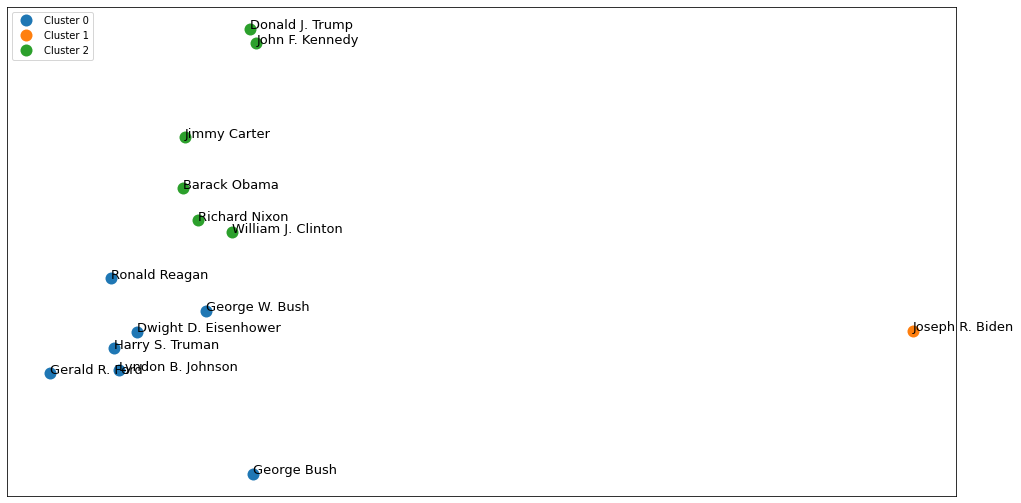

In [47]:
groups = final_dense_df.groupby('Label')
cluster_names_0 = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'}
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.X, group.Y, marker='o', linestyle='', ms=12, 
            label=cluster_names_0[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(final_dense_df)):
    ax.text(final_dense_df.loc[i]['X'], final_dense_df.loc[i]['Y'], final_dense_df.loc[i]['President'], size=13)  

    
    
plt.show()

NER

In [48]:
def specify_NER(raw_text):
  doc = ner.name(raw_text, language='en_core_web_sm')
  print(doc)
  text_label = [(X.text, X.label_) for X in doc]
  for text, label in text_label:
    if(label != 'GPE'):
      raw_text = raw_text.replace(text, label)
  return raw_text

In [49]:
input_text = "That U.S.A. poster-print e.g the U.S costs $12.40 that created in 2008 by Jeff Atwood and Joel Spolsky."
specify_NER(input_text)

(U.S.A., U.S, 12.40, 2008, Jeff Atwood, Joel Spolsky)


'That U.S.A. poster-print e.g the U.S costs $MONEY that created in DATE by PERSON and PERSON.'

In [35]:
NER = spacy.load("en_core_web_sm")
raw_text = 'That U.S.A. poster-print e.g the U.S costs $12.40'
text1= NER(raw_text)
displacy.render(text1,style="ent",jupyter=True)



In [36]:

s = "That U.S.A. and Nicolas poster-print e.g the U.S costs $12.40"
doc = NER(s)
word_tokens = tokenize_text(s)

a = " ".join([t.text if not t.ent_type_ else t.ent_type_ for t in doc])
print(tokenize_text(a))


['That', 'GPE', 'and', 'PERSON', 'poster', '-', 'print', 'e.g', 'the', 'GPE', 'costs', 'MONEY']


In [37]:
l = tokenize_text('That U.S.A. poster-print e.g the U.S costs $12.40 amir. hello')
t = 'That U.S.A. poster-print e.g the U.S costs $12.40 amir. hello'
def punct(text):
    text = ' '.join([t for t in tokenize_text(text) if len(t) > 1])
    text = ' '.join(word.strip(punctuation) for word in tokenize_text(text))
    return text
        
#punct(t) 
import re, string

def test(text):
    out =' '.join([word for word in tokenize_text(text) if word not in string.punctuation])

    return out
print(test(t))
print(punct(t))
#print(l)

That U.S.A. poster-print e.g the U.S costs $12.40  amir hello
That U.S.A poster-print e.g the U.S costs 12.40  amir hello


In [38]:
l = 'That U.S.A. poster-print e.g the U.S costs $12.40 3th amir. hello 7. 9 2th 2nd2 5-year $56 $4 1890'

def remove_num(t):
    my_reg = r'\$?\d+\.?\d*\w*\d*'
    text = re.sub(my_reg, '', t)
    text = re.sub(' +', ' ', text)
    return text

y = remove_num(l)
print(test(y))


That U.S.A. poster-print e.g the U.S costs amir hello year


In [39]:
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [40]:
from nltk.tokenize import word_tokenize
min_len = 2
l = 'That U.S.A. poster-print e.g the U.S cs $12.40 3th am'
t = word_tokenize(l)
if min_len>1:
    text = ' '.join([word for word in t if len(word)>min_len]) 

In [41]:
text

'That U.S.A. poster-print e.g the U.S 12.40 3th'

In [42]:
text = '[Laughter]poster-print The President. That 1993s [Applause] Asia—the asia-pacific'
tt = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
tt

'poster-print The President. That 1993s  Asia—the asia-pacific'